# Predicting crowd in NTU Buses using Object Recognition approaches

In this project, our team is designing an object recognition approach to predict how crowded a bus is.

We first import the necessary libraries.

In [18]:
import cv2
import argparse
import numpy as np

We make use of the pre-trained model found online by loading the files `yolov3.txt`, `yolov3.weights`, and `yolov3.cfg`.

In [19]:
# read class names from text file
classes = None
with open('yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# generate different colors for different classes 
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# read pre-trained model and config file
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

We define two necessary functions, `get_output_layers` and `draw_bounding_box`, which will subsequently be used in the object recognition process.

In [20]:
# function to get the output layer names in the architecture
def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])
    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

We define a function which determines whether an object is present in an image considering its non-max suppression threshold.

In [21]:
def yoloimage(image, num):
    Width = image.shape[1]
    Height = image.shape[0]
    scale = 0.00392

    # create input blob 
    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

    # set input blob for the network
    net.setInput(blob)
    
    # run inference through the network and gather predictions from output layers
    outs = net.forward(get_output_layers(net))

    # initialization
    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4

    # for each detection from each output layer, get the confidence, class id, bounding box parameters and ignore weak detections (confidence < 0.5)
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    # apply non-max suppression (nms)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # go through the remaining detections after nms and draw bounding box
    for i in indices:
        i = i[0]
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        draw_bounding_box(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

     # save output image to disk
    name = "folder/objectt" + str(num) + ".jpg"
    cv2.imwrite(name, image)
    return boxes, class_ids


We define a function to identify only the object `Person` and to remove duplicates.

In [22]:
def is_it_a_man(boxes, classids):
    is_it_a_man_list = list(boxes[i] for i in range (len(classids)) if classids[i] == 0) 
    return (is_it_a_man_list)

In [23]:
def check_var(is_it):
    is_it_note = []
    for i in range (len(is_it)):
        for j in range (len(is_it)):
            if j>i:
                if (is_it[i][0]-is_it[j][0])**2 < 25 and (is_it[i][1]-is_it[j][1])**2 < 25:
                    if is_it[i][0]>is_it[j][0]:
                        is_it_note.append(is_it[i])
                    else:
                        is_it_note.append(is_it[j])
                        
    # remove duplicate manual
    for i in is_it_note:
        while i in is_it:
            is_it.remove(i)
    return is_it

We extract some footages -- in an interval of 0.5 seconds -- from a video we want to analyze.

In [30]:
from scipy import ndimage
import time

vidcap = cv2.VideoCapture('vid.mp4')
i = 0
data_of_man = []
data_of_num_man = []

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        boxes, classids = yoloimage(ndimage.rotate(image, 270), i)
        print("Frame", i + 1)
        print(boxes, classids)
        print(check_var(is_it_a_man(boxes,classids)))
        data_of_man.append(is_it_a_man(boxes,classids))
        data_of_num_man.append(len(check_var(is_it_a_man(boxes,classids))))
    return hasFrames

sec = 20
frameRate = 0.5 #//it will capture image in each 0.5 second
count = 1
success = getFrame(sec)
limit = 60
while success and sec < limit:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)
    i += 1

data_of_frame= list(j for j in range(1,i+1))

Frame 1
[] []
[]
Frame 1
[[269.5, 366.5, 31, 79]] [10]
[]
Frame 2
[[29.5, 416.0, 69, 116], [34.0, 416.0, 58, 112]] [10, 10]
[]
Frame 3
[] []
[]
Frame 4
[] []
[]
Frame 5
[] []
[]
Frame 6
[] []
[]
Frame 7
[] []
[]
Frame 8
[[254.5, 259.5, 93, 277]] [0]
[[254.5, 259.5, 93, 277]]
Frame 9
[[96.5, 307.0, 87, 154], [98.0, 250.5, 154, 373], [315.5, 262.0, 27, 88]] [24, 0, 0]
[[98.0, 250.5, 154, 373], [315.5, 262.0, 27, 88]]
Frame 10
[[271.5, 257.0, 33, 104], [315.5, 259.0, 33, 112]] [0, 0]
[[271.5, 257.0, 33, 104], [315.5, 259.0, 33, 112]]
Frame 11
[[205.5, 248.5, 41, 137], [297.0, 261.5, 34, 103], [254.0, 262.0, 46, 134]] [0, 0, 0]
[[205.5, 248.5, 41, 137], [297.0, 261.5, 34, 103], [254.0, 262.0, 46, 134]]
Frame 12
[[126.0, 250.5, 64, 163], [277.5, 248.5, 25, 79], [127.5, 253.0, 55, 162], [186.5, 265.5, 49, 151], [239.5, 264.5, 45, 141], [295.0, 270.0, 54, 166]] [0, 0, 0, 0, 0, 0]
[[126.0, 250.5, 64, 163], [277.5, 248.5, 25, 79], [186.5, 265.5, 49, 151], [239.5, 264.5, 45, 141], [295.0, 270.0,

Frame 26
[[48.0, 236.5, 70, 149], [165.0, 330.0, 74, 138], [-1.0, 277.0, 86, 348], [210.5, 379.0, 89, 152], [186.0, 298.5, 144, 329], [247.0, 233.5, 50, 89], [49.5, 236.0, 59, 150], [129.5, 241.5, 53, 135], [165.5, 342.5, 59, 123], [301.5, 251.5, 27, 45]] [0, 24, 0, 24, 0, 0, 0, 0, 24, 0]
[[48.0, 236.5, 70, 149], [-1.0, 277.0, 86, 348], [186.0, 298.5, 144, 329], [247.0, 233.5, 50, 89], [129.5, 241.5, 53, 135], [301.5, 251.5, 27, 45]]
Frame 27
[[98.5, 242.0, 65, 130], [161.0, 329.5, 76, 149], [-2.0, 276.0, 94, 364], [209.5, 299.0, 139, 332], [30.5, 234.5, 51, 103], [248.5, 234.0, 53, 88], [105.0, 239.5, 54, 137], [163.5, 342.5, 59, 123], [305.0, 251.0, 30, 44]] [0, 24, 0, 0, 0, 0, 0, 24, 0]
[[98.5, 242.0, 65, 130], [-2.0, 276.0, 94, 364], [209.5, 299.0, 139, 332], [30.5, 234.5, 51, 103], [248.5, 234.0, 53, 88], [105.0, 239.5, 54, 137], [305.0, 251.0, 30, 44]]
Frame 28
[[158.5, 333.5, 73, 137], [0.0, 286.5, 76, 351], [176.0, 280.0, 102, 354], [206.5, 306.0, 145, 324], [248.5, 232.0, 49, 

Frame 65
[] []
[]
Frame 66
[] []
[]
Frame 67
[] []
[]
Frame 68
[] []
[]
Frame 69
[] []
[]
Frame 70
[] []
[]
Frame 71
[] []
[]
Frame 72
[] []
[]
Frame 73
[] []
[]
Frame 74
[] []
[]
Frame 75
[] []
[]
Frame 76
[] []
[]
Frame 77
[] []
[]
Frame 78
[] []
[]
Frame 79
[] []
[]
Frame 80
[] []
[]


Harnessing DataFrame function from `pandas` module, we produce a summary based on our observation for user's convenience

In [34]:
import numpy as np
import pandas as pd

#initialize data of lists
dct = {"Frame": data_of_frame,
    "Number of people":data_of_num_man[:len(data_of_frame)]  
}
df = pd.DataFrame(dct)
df.index = data_of_frame
df

,Frame,Number of people
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,1
10,10,2


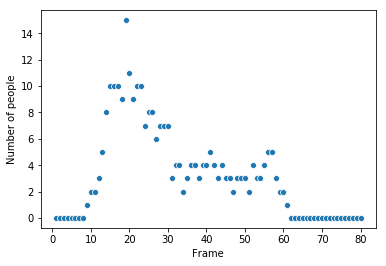

In [36]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.scatterplot(df["Frame"], df["Number of people"])